In [1]:
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [2]:
tqdm.pandas()

In [3]:
pl.seed_everything(42)

Seed set to 42


42

In [4]:
df = pd.read_csv("medium_blog_dataset.csv", parse_dates=['dates'])

df.dates = pd.to_datetime(df.dates)

years = df.dates.dt.year
months = df.dates.dt.month
days = df.dates.dt.day

In [5]:
df.head()

,dates,y,X
0,2021-01-01,21.919606,10.496714
1,2021-01-02,23.172702,10.631643
2,2021-01-03,21.278713,11.338640
3,2021-01-04,26.909878,13.173454
4,2021-01-05,27.260727,13.955685


In [6]:
rows = []

indx = 0
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
    year = years[indx],
    month = months[indx],
    day = days[indx],
    y = row.y,
    X = row.X
    )

    rows.append(row_data)
    indx += 1

features_df = pd.DataFrame(rows)

100%|██████████| 500/500 [00:00<00:00, 21739.80it/s]


In [7]:
features_df.head()

,year,month,day,y,X
0,2021,1,1,21.919606,10.496714
1,2021,1,2,23.172702,10.631643
2,2021,1,3,21.278713,11.338640
3,2021,1,4,26.909878,13.173454
4,2021,1,5,27.260727,13.955685


In [8]:
training_size = int(len(features_df) * 0.9)
training_size

450

In [9]:
train_df , test_df = features_df[:training_size], features_df[training_size+1:]
train_df.shape, test_df.shape

((450, 5), (49, 5))

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [11]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns=train_df.columns
)
train_df.shape

(450, 5)

In [12]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns=test_df.columns
)

test_df.head()

,year,month,day,y,X
451,1.0,-0.636364,0.800000,0.469967,0.436068
452,1.0,-0.636364,0.866667,0.425548,0.418034
453,1.0,-0.636364,0.933333,0.480669,0.426687
454,1.0,-0.636364,1.000000,0.435110,0.405878
455,1.0,-0.454545,-1.000000,0.423406,0.369562


In [13]:
def create_sequences(input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)
    for i in tqdm(range(data_size - sequence_length)):
        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]
        sequences.append((sequence,label))

    return sequences

In [14]:
SEQUENCE_LENGTH = 10

train_sequences = create_sequences(train_df, 'X', SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df, 'X', SEQUENCE_LENGTH)


100%|██████████| 39/39 [00:00<00:00, 19492.12it/s]


In [15]:
class BTCDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )


In [16]:
class BTCPriceDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size = 8):
        super().__init__()
        self.train_sequence = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = BTCDataset(self.train_sequence)
        self.test_dataset = BTCDataset(self.test_sequences)

    def train_dataloader(self):
        print("coming here")
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers=0
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )   

In [17]:
N_EPOCHS = 8
BATCH_SIZE = 16

data_module = BTCPriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

len(data_module.train_dataloader())

# for i in data_module.train_dataloader():
#     print(i['sequence'].shape)
#     print(i['label'].shape)
#     break

coming here


28

In [18]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True, 
            num_layers = n_layers,
            dropout = 0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)


    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [19]:
class BTCPricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()

        self.model = PricePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0

        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("validation_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar = True, logger = True)
        return loss
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [20]:
model = BTCPricePredictor(n_features=train_df.shape[1])

In [21]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename='best-checkpoint',
    save_top_k= 1,
    verbose=True,
    monitor='validation_loss',
    mode = 'min'
)

# Create log files for tensorboard visualization 
logger = TensorBoardLogger('lightning_logs', name='btc-price')

# Stop the training if there is no progress in validation loss
early_stopping_callback = EarlyStopping(monitor='validation_loss', patience=20)

# Create a pl-lightning trainer
trainer = pl.Trainer(
    logger = logger,
    callbacks=[checkpoint_callback],
    max_epochs= N_EPOCHS,
    enable_progress_bar=True,
    num_sanity_val_steps=1
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, data_module)

c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory checkpoints exists and is not empty.

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 201 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.805     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.32it/s]

c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Reuel Group\anaconda3\envs\causal\lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


coming here
Epoch 0: 100%|██████████| 28/28 [00:00<00:00, 74.21it/s, v_num=5, train_loss=0.263, validation_loss=0.0575]

Epoch 0, global step 28: 'validation_loss' reached 0.05748 (best 0.05748), saving model to 'checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 28/28 [00:00<00:00, 80.29it/s, v_num=5, train_loss=0.258, validation_loss=0.0585]   

Epoch 1, global step 56: 'validation_loss' was not in top 1


Epoch 2: 100%|██████████| 28/28 [00:00<00:00, 80.97it/s, v_num=5, train_loss=0.216, validation_loss=0.0515]   

Epoch 2, global step 84: 'validation_loss' reached 0.05147 (best 0.05147), saving model to 'checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 3: 100%|██████████| 28/28 [00:00<00:00, 79.89it/s, v_num=5, train_loss=0.147, validation_loss=0.0327]  

Epoch 3, global step 112: 'validation_loss' reached 0.03269 (best 0.03269), saving model to 'checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 28/28 [00:00<00:00, 80.13it/s, v_num=5, train_loss=0.082, validation_loss=0.0156]   

Epoch 4, global step 140: 'validation_loss' reached 0.01563 (best 0.01563), saving model to 'checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 5: 100%|██████████| 28/28 [00:00<00:00, 79.41it/s, v_num=5, train_loss=0.0367, validation_loss=0.0133]  

Epoch 5, global step 168: 'validation_loss' reached 0.01334 (best 0.01334), saving model to 'checkpoints\\best-checkpoint-v1.ckpt' as top 1


Epoch 6: 100%|██████████| 28/28 [00:00<00:00, 80.11it/s, v_num=5, train_loss=0.0117, validation_loss=0.0248]  

Epoch 6, global step 196: 'validation_loss' was not in top 1


Epoch 7: 100%|██████████| 28/28 [00:00<00:00, 81.93it/s, v_num=5, train_loss=0.00352, validation_loss=0.0442] 

Epoch 7, global step 224: 'validation_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 28/28 [00:00<00:00, 81.44it/s, v_num=5, train_loss=0.00352, validation_loss=0.0442]


In [23]:
# Pick the best checkpoint/model
trained_model = BTCPricePredictor.load_from_checkpoint("checkpoints/best-checkpoint.ckpt", n_features= train_df.shape[1] )
trained_model.freeze()

In [24]:
# Create a test dataset 
test_dataset = BTCDataset(test_sequences)
predictions = []
labels = []

# Pass each sequence through the trained model to get predictions
for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    # Get the output label for a particilar sequence
    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

100%|██████████| 39/39 [00:00<00:00, 1060.01it/s]


In [25]:
# Descale the values to normal 
descaler = MinMaxScaler()
descaler.min_ , descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
    
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

ValueError: x and y must have same first dimension, but have shapes (500,) and (39,)

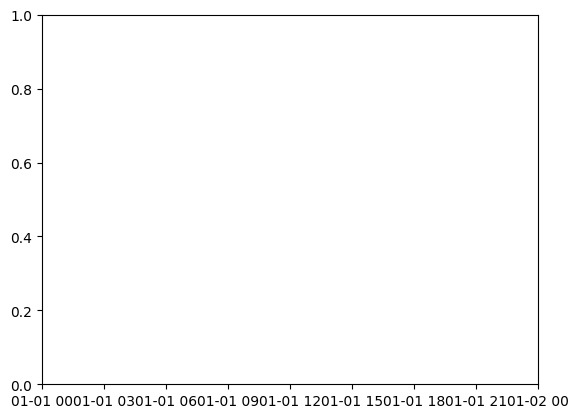

In [29]:
# To plot the test data prediction against time we get the timestamp column for the data
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)
test_data = pd.DataFrame(columns=df.columns)

plt.plot(df.dates[:len(predictions_descaled)], predictions_descaled)
plt.plot(df.dates[:len(labels_descaled)], labels_descaled)